In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# The MNIST Problem

The MNIST database (Modified National Institute of Standards and Technology database[1]) is a large database of handwritten digits that is commonly used for training and testing advanced machine learning algorithms. General references are:

**MNIST database**. Wikipedia. https://en.wikipedia.org/wiki/MNIST_database.

**THE MNIST DATABASE of handwritten digits**. Yann LeCun, Courant Institute, NYU Corinna Cortes, Google Labs, New York Christopher J.C. Burges, Microsoft Research, Redmond. http://yann.lecun.com/exdb/mnist/

**Classification datasets results**. Rodrigo Benenson. https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

The MNIST database contains 60,000 training images and 10,000 testing images. In our dataset the images will be 32 x 32 greyscale digit rasters.
In order to manage our computations in reasonable time, we are going to work only with the test subset, which we will further randomly split in a 20% train and validation subset and an 80% test subset.

### Student contributions

* Student `Gupta, Kush` has done exploratory research and data analysis on the studied topics, and descriptive analysis of the obtained results.
* Student `Nemeth, Sebestyen` has implemented the data preprocessing and fitting methods and visualized the results.
* The students worked together on definining the workplan of the project, recapping the methods learnt on the laboratory sessions and analyzing the results.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from sklearn.pipeline import Pipeline

import math

## Loading Data

Notice that the shape of each pattern is given by a $32 \times 32 \times 1$ tensor. Thus, you may have to reshape it to either a matrix or a vector depending on the task you want to perform.

In [4]:
!wget -q https://raw.githubusercontent.com/sebinemeth/ftdl-data/main/mnist_32_32.bnch.joblib -O mnist_32_32.bnch.joblib 

In [5]:
f_bnch = "/content/mnist_32_32.bnch.joblib"
mnist = joblib.load(f_bnch)
print(mnist.keys())

print("data_shape: {0}".format(mnist['data'].shape))
print("data_test_shape: {0}".format(mnist['data_test'].shape))

dict_keys(['DESCR', 'target', 'target_test', 'data', 'data_test'])
data_shape: (60000, 1024)
data_test_shape: (10000, 1024)


In [6]:
X = mnist['data_test']
Y = mnist['target_test']

print(Y)

[7 2 1 ... 4 5 6]


In [7]:
#Generating missing labels for the columns
labels = [f'p_{math.floor(i/32)}_{i%32}' for i in range(1024)]
print(labels)

['p_0_0', 'p_0_1', 'p_0_2', 'p_0_3', 'p_0_4', 'p_0_5', 'p_0_6', 'p_0_7', 'p_0_8', 'p_0_9', 'p_0_10', 'p_0_11', 'p_0_12', 'p_0_13', 'p_0_14', 'p_0_15', 'p_0_16', 'p_0_17', 'p_0_18', 'p_0_19', 'p_0_20', 'p_0_21', 'p_0_22', 'p_0_23', 'p_0_24', 'p_0_25', 'p_0_26', 'p_0_27', 'p_0_28', 'p_0_29', 'p_0_30', 'p_0_31', 'p_1_0', 'p_1_1', 'p_1_2', 'p_1_3', 'p_1_4', 'p_1_5', 'p_1_6', 'p_1_7', 'p_1_8', 'p_1_9', 'p_1_10', 'p_1_11', 'p_1_12', 'p_1_13', 'p_1_14', 'p_1_15', 'p_1_16', 'p_1_17', 'p_1_18', 'p_1_19', 'p_1_20', 'p_1_21', 'p_1_22', 'p_1_23', 'p_1_24', 'p_1_25', 'p_1_26', 'p_1_27', 'p_1_28', 'p_1_29', 'p_1_30', 'p_1_31', 'p_2_0', 'p_2_1', 'p_2_2', 'p_2_3', 'p_2_4', 'p_2_5', 'p_2_6', 'p_2_7', 'p_2_8', 'p_2_9', 'p_2_10', 'p_2_11', 'p_2_12', 'p_2_13', 'p_2_14', 'p_2_15', 'p_2_16', 'p_2_17', 'p_2_18', 'p_2_19', 'p_2_20', 'p_2_21', 'p_2_22', 'p_2_23', 'p_2_24', 'p_2_25', 'p_2_26', 'p_2_27', 'p_2_28', 'p_2_29', 'p_2_30', 'p_2_31', 'p_3_0', 'p_3_1', 'p_3_2', 'p_3_3', 'p_3_4', 'p_3_5', 'p_3_6', 'p_3_7

In [8]:
df = pd.DataFrame(data=X, columns=labels)
df['target'] = Y

#checking, if the desired dataframe looks good.
df.head()

,p_0_0,p_0_1,p_0_2,p_0_3,p_0_4,p_0_5,p_0_6,p_0_7,p_0_8,p_0_9,...,p_31_23,p_31_24,p_31_25,p_31_26,p_31_27,p_31_28,p_31_29,p_31_30,p_31_31,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


## Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms.

### Some examples

Plot 10 randomly chosen digit images as 5 x 2 subplots.

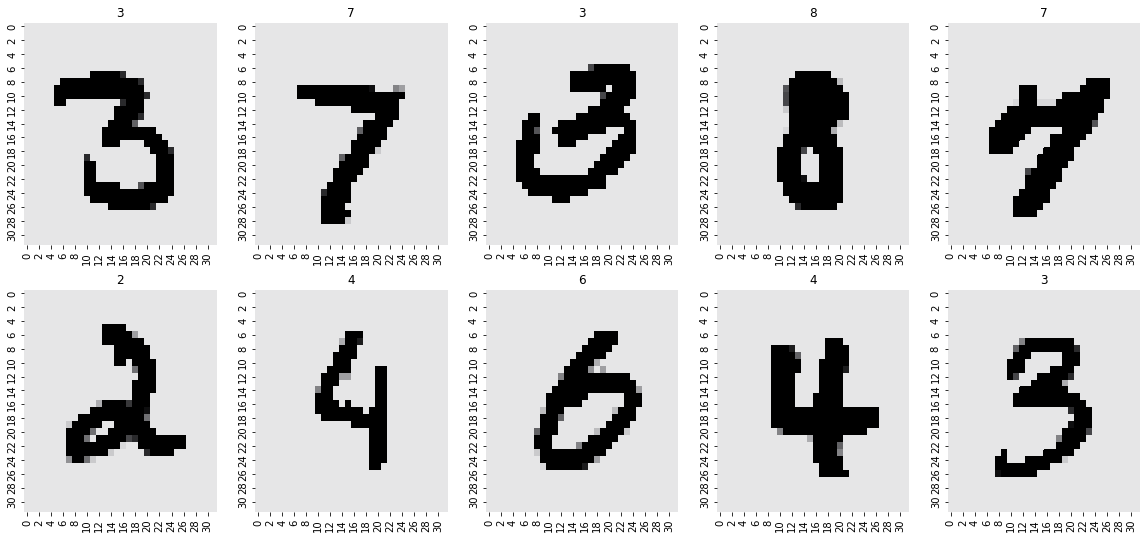

In [9]:
cMap = sns.cubehelix_palette(n_colors=50, hue=0.05, rot=0, light=0.9, dark=0)

label_columns = labels
plt.figure(figsize=(20, 9))

for i in range(10):
    plt.subplot(2, 5, i+1)
    #select images randomly
    idx = np.random.randint(low=0, high=len(Y))
    plt.title(int(Y[idx]))
    h_map = sns.heatmap(df[label_columns].iloc[idx].values.reshape(32, 32),
                    vmin=0., vmax=16., 
                    cmap=cMap, 
                    cbar=False,
                    #annot=True, 
                   )
plt.show()

### Descriptive analysis

Build a DataFrame to make easier the exploratory analysis.

In [10]:
#DataFrame for EDA
df.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
p_0_0,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_0_1,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_0_2,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_0_3,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_0_4,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
p_31_28,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_31_29,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_31_30,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
p_31_31,10000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


Describe the basic statistics of the pixels on the positions in the range `[494 : 502]` of the reshaped patterns.

In [11]:
df_center = pd.DataFrame(data=X[:,494:502], columns=labels[494:502])
df_center.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
p_15_14,10000.0,84.41,106.12,0.0,0.0,2.0,208.0,255.0
p_15_15,10000.0,96.37,109.08,0.0,0.0,25.0,233.0,255.0
p_15_16,10000.0,113.71,114.30,0.0,0.0,72.0,252.0,255.0
p_15_17,10000.0,127.31,112.31,0.0,0.0,132.0,253.0,255.0
p_15_18,10000.0,132.80,109.88,0.0,0.0,149.0,252.0,255.0
p_15_19,10000.0,128.99,112.47,0.0,0.0,140.0,252.0,255.0
p_15_20,10000.0,109.99,111.90,0.0,0.0,67.0,252.0,255.0
p_15_21,10000.0,80.92,104.67,0.0,0.0,0.0,193.0,255.0


### Boxplots

Compute and display the boxplots of pixels in the range `[494 : 502]`.

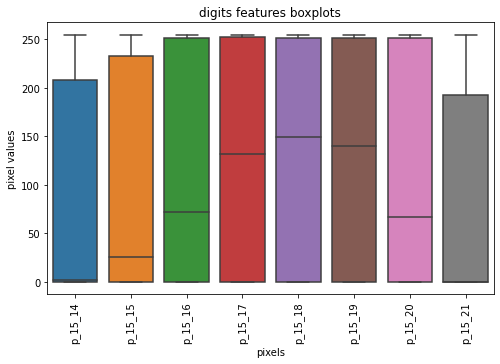

In [12]:
#Box Plot for visualization
plt.figure( figsize=(8, 5))
plt.title("digits features boxplots")
sns.set_style("darkgrid")
bx_plot = sns.boxplot(data=df_center)
plt.xticks(rotation=90)
plt.xlabel("pixels")
plt.ylabel("pixel values")
plt.show()

### Histograms and scatterplots

Plot pairplots and histograms over the previous pixel range using `sns.pairplot`.  
To do so select first two target digits (e.g., 2 and 7) and apply `pairplot` only on patterns from those two targets.

In [13]:
# add targets to df containing center pixels
df_center['target'] = Y
df_center.head()

,p_15_14,p_15_15,p_15_16,p_15_17,p_15_18,p_15_19,p_15_20,p_15_21,target
0,0,0,0,0,0,129,254,238,7
1,253,233,35,0,0,0,0,0,2
2,0,57,237,205,8,0,0,0,1
3,0,0,0,0,0,0,31,200,0
4,0,0,0,0,0,134,252,211,4


In [14]:
# select images with label 0 or 1
df_01_center = df_center[(df_center['target']==0) | (df_center['target']==1)]
df_01_center.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
p_15_14,2115.0,43.98,78.39,0.0,0.0,0.0,53.5,255.0
p_15_15,2115.0,96.71,104.53,0.0,0.0,50.0,208.5,255.0
p_15_16,2115.0,133.51,122.65,0.0,0.0,211.0,253.0,255.0
p_15_17,2115.0,117.20,118.02,0.0,0.0,87.0,253.0,255.0
p_15_18,2115.0,56.72,89.26,0.0,0.0,0.0,98.0,255.0
p_15_19,2115.0,19.23,53.17,0.0,0.0,0.0,0.0,255.0
p_15_20,2115.0,22.89,62.94,0.0,0.0,0.0,0.0,255.0
p_15_21,2115.0,45.14,87.89,0.0,0.0,0.0,15.0,255.0
target,2115.0,0.54,0.50,0.0,0.0,1.0,1.0,1.0


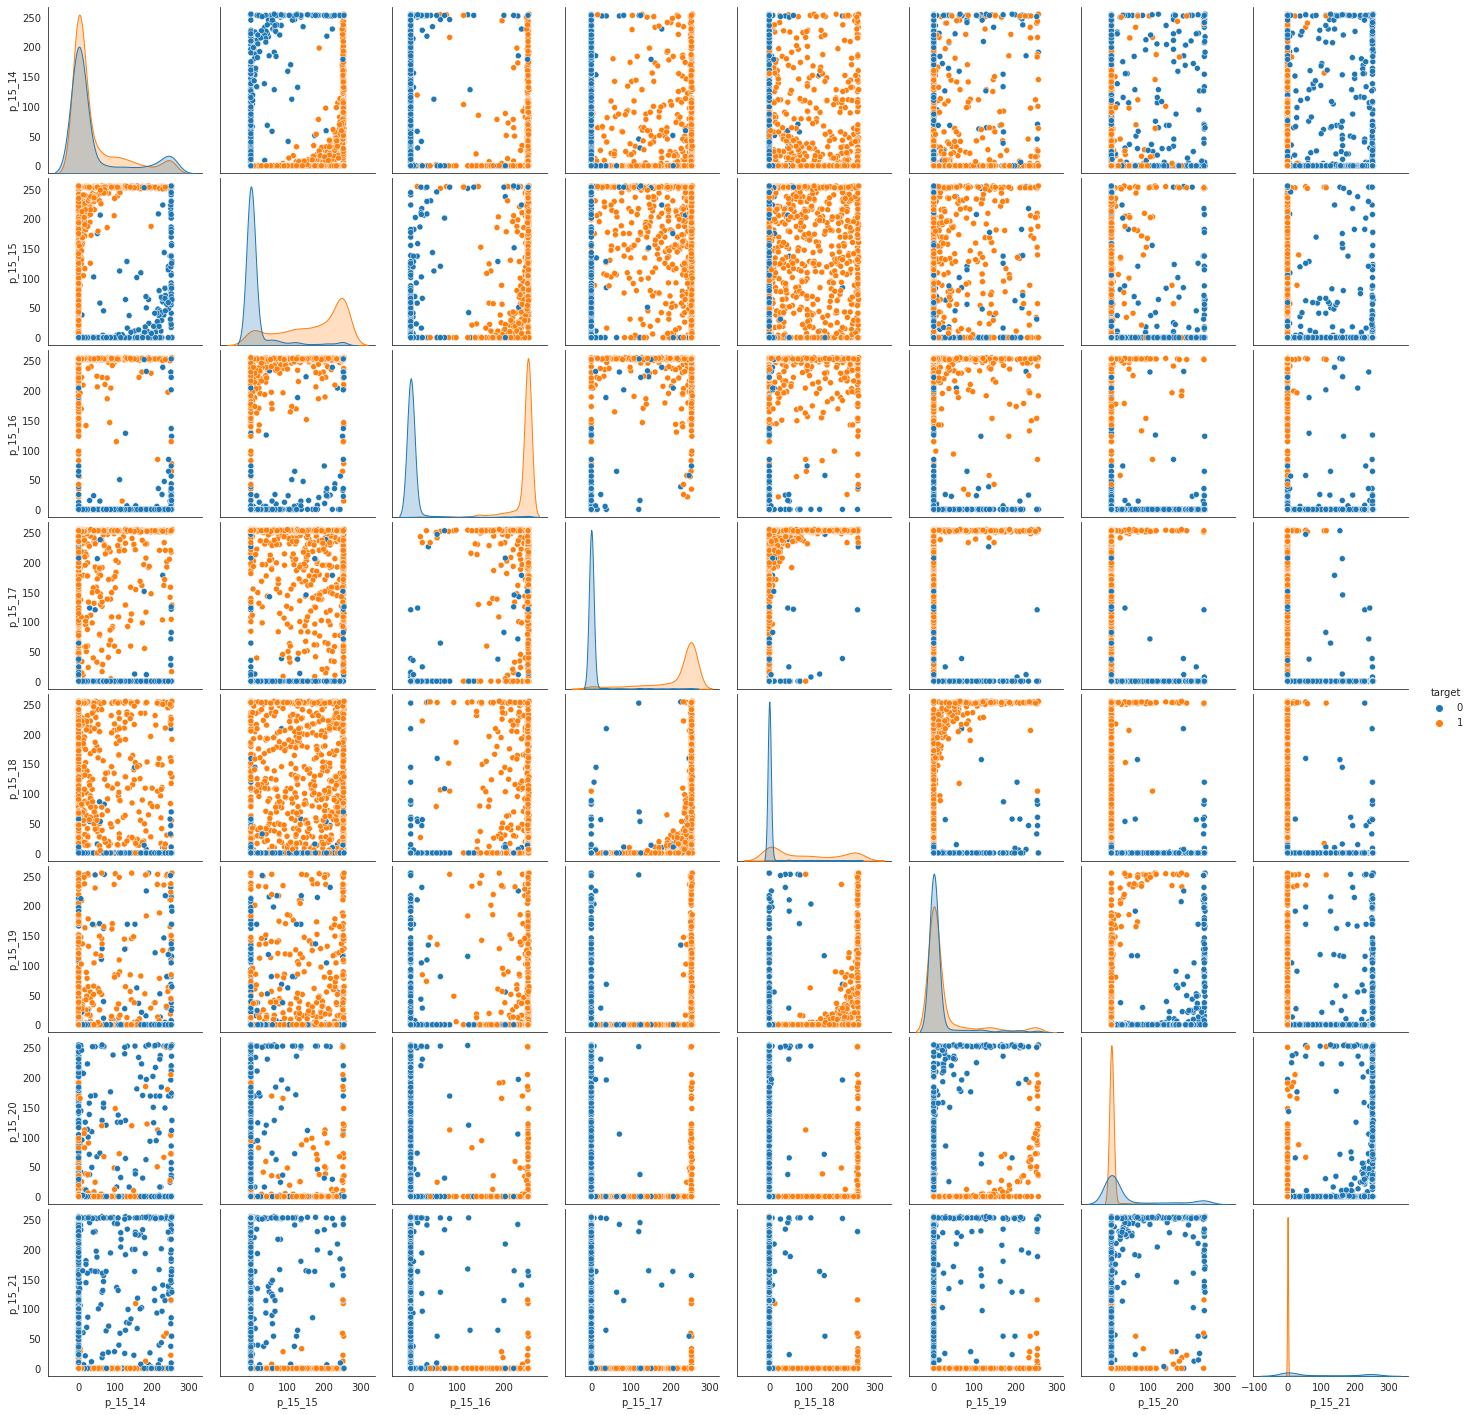

In [15]:
# select two target digits and apply sns.pairplot on the indicated pixel range
l_columns = labels[494:502]
sns.set_style("white")
pair_plot = sns.pairplot(df_01_center, hue='target', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

### Correlations

Use the previous pixel range but drop the `target` column.

Use directly a heatmap to display the correlations.

In [16]:
#display the correlations of the pixel range as a heatmap
df_01_center_data = df_01_center.drop(columns=['target'], inplace=False)
df_01_center_data.corr().round(decimals=3)

,p_15_14,p_15_15,p_15_16,p_15_17,p_15_18,p_15_19,p_15_20,p_15_21
p_15_14,1.000,0.363,0.017,-0.017,0.043,0.176,0.208,0.144
p_15_15,0.363,1.000,0.777,0.620,0.386,0.104,-0.194,-0.377
p_15_16,0.017,0.777,1.000,0.893,0.548,0.096,-0.314,-0.534
p_15_17,-0.017,0.620,0.893,1.000,0.712,0.175,-0.281,-0.494
p_15_18,0.043,0.386,0.548,0.712,1.000,0.486,-0.108,-0.301
p_15_19,0.176,0.104,0.096,0.175,0.486,1.000,0.449,0.088
p_15_20,0.208,-0.194,-0.314,-0.281,-0.108,0.449,1.000,0.679
p_15_21,0.144,-0.377,-0.534,-0.494,-0.301,0.088,0.679,1.000


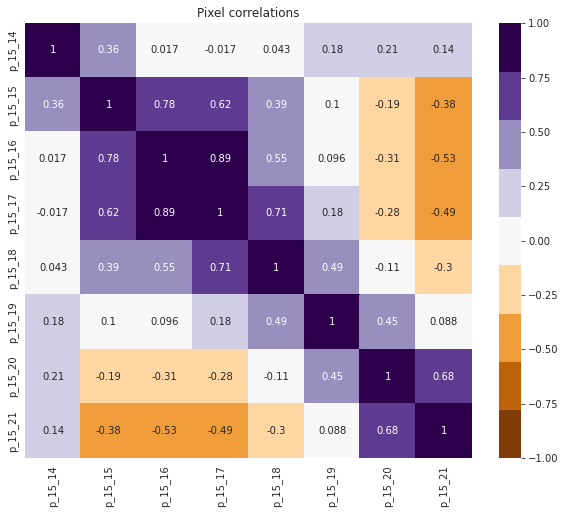

In [17]:
n_colors = 9
cMap = plt.cm.get_cmap("PuOr",lut=n_colors ) 

plt.figure( figsize=(10, 8))
plt.title('Pixel correlations')
h_map = sns.heatmap(df_01_center_data.corr().values,
                    vmin=-1., vmax=1., 
                    cmap=cMap, 
                    annot=True, 
                    xticklabels=list(df_01_center_data),
                    yticklabels=list(df_01_center_data))
plt.xticks(rotation=90) 

plt.show()

### Data Analysis Conclusions

Write down here a summary of your conclusions after the basic data analysis

1. Upon loading the data we analyzed the structure and distribution of the data. As there were no labels for the columns. So, we created the column labels for it and used describe function to observe other aspects of provided data. 
2.We observed that each digit was written in several different styles. So we choose specific region of interset(pixels) in the whole image. We could see that the most interesting region was from the column 494 label(p_15_14) to 502 column label (*p_15_21*). 
3. In the pair plot we could observe that at p_15_16, the pixel values for digit 0 and 1 have a very distinctive distribution where as at p_15_14 and at p_15_19 they have quite similar pixel distribution region.
4.Hence, for better analysis we created a new data frame. Using the heat map we observed that in the image the regions from P_15_15 to P_15_18 are highly corelated. Also, we tried to analyze the digits 0 & 1 and we found that using the pair plots and pixel correlation plots we could distinguish between 0 & 1. As for 0, the centeroid pixels are white and dark for 1.

# Classiffiers

We are going to build a $k$-NN and an MLP classifier **over the test dataset**.  
But before working with any classifier, we split first the test dataset into a train-validation and a test subset.  
Use for this the class `StratifiedShuffleSplit` from scikit-learn. Set the `test_size` parameter to either `0.5` or `0.75`.

### Splitting the test dataset

In [18]:
# split the test dataset here

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
train, test = next(splitter.split(X, Y))
x_train = X[train]
x_test = X[test]

y_train = Y[train]
y_test = Y[test]

print(f'Train samples:\t{x_train.shape[0]}\nTest samples:\t{x_test.shape[0]}')

Train samples:	7500
Test samples:	2500


## k-NN Classification

### Grid Search of Optimal Number of neighbors

In [19]:
#define a knn classifier and use CV to estimate the best number of neighbors
knn_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('knn', KNeighborsClassifier(weights='distance'))])

n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

k_candidates = [1] + [1 + 2**k for k in range(0, 6)]
param_grid = {'knn__n_neighbors': k_candidates}

knn_gscv = GridSearchCV(knn_classifier, 
                        param_grid=param_grid, 
                        cv=skf, 
                        scoring='accuracy', 
                        return_train_score=True, 
                        n_jobs=-1, 
                        verbose=1)

print("GridSearch over a list of neighbors: {0}".format(k_candidates))
knn_gscv.fit(x_train, y_train)

GridSearch over a list of neighbors: [1, 2, 3, 5, 9, 17, 33]
Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 5, 9, 17, 33]},
             return_train_score=True, scoring='accuracy', verbose=1)

### Search Results 

We first examine the test scores of the 5 best hyperparameters.

In [20]:
#transfor the CV results into a DataFrame and display the 5 best results
df_nn_k_search = pd.DataFrame.from_dict(knn_gscv.cv_results_)

display(df_nn_k_search[["param_knn__n_neighbors", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_knn__n_neighbors,mean_test_score
3,5,0.911467
2,3,0.911200
0,1,0.905733
1,2,0.905733
4,9,0.903867


We analyze the CV results to check whether the CV ranges used are correct.

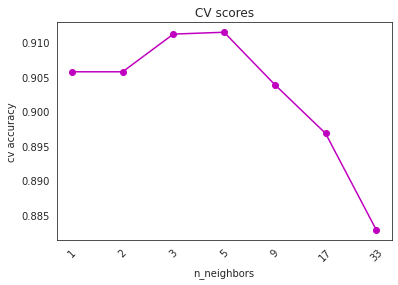

In [21]:
#plot the test scores that correspond to each number of neighbors
plt.title("CV scores")
plt.xlabel('n_neighbors')
plt.ylabel('cv accuracy')
plt.xticks(range(len(k_candidates)), k_candidates, rotation=45)
plt.plot( df_nn_k_search['mean_test_score'], 'mo-')
plt.show()

### Fine tune selection of K

In [22]:
# fine-tune K selection
max_idx = np.argmax(list(df_nn_k_search['mean_test_score']))
from_idx = k_candidates[max_idx - 1]
to_idx = k_candidates[max_idx + 1]

knn_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('knn', KNeighborsClassifier(weights='distance'))])

n_folds = 10
skf = StratifiedKFold(n_folds, 
                      shuffle=True)

k_candidates = range(from_idx + 1, to_idx)
param_grid = {'knn__n_neighbors': k_candidates}

knn_gscv = GridSearchCV(knn_classifier, 
                        param_grid=param_grid, 
                        cv=skf, 
                        scoring='accuracy', 
                        return_train_score=True, 
                        n_jobs=-1, 
                        verbose=1)

print("GridSearch over a list of neighbors: {0}".format(k_candidates))
knn_gscv.fit(x_train, y_train)


GridSearch over a list of neighbors: range(4, 9)
Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(weights='distance'))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(4, 9)},
             return_train_score=True, scoring='accuracy', verbose=1)

In [23]:

#transfor the CV results into a DataFrame and display the 5 best results
df_nn_k_search = pd.DataFrame.from_dict(knn_gscv.cv_results_)

display(df_nn_k_search[["param_knn__n_neighbors", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_knn__n_neighbors,mean_test_score
0,4,0.914533
2,6,0.913200
1,5,0.911867
4,8,0.909200
3,7,0.908933


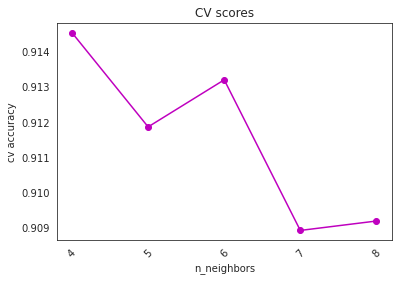

In [24]:
#plot the test scores that correspond to each number of neighbors
plt.title("CV scores")
plt.xlabel('n_neighbors')
plt.ylabel('cv accuracy')
plt.xticks(range(len(k_candidates)), k_candidates, rotation=45)
plt.plot( df_nn_k_search['mean_test_score'], 'mo-')
plt.show()

### Test Accuracy and Confusion Matrix

Precision and recall can also be defined for multiclass problems but we will skip them.

In [25]:
#compute the test predictions, their accuracy and confusion matrix and discuss your results
best_k = knn_gscv.best_params_['knn__n_neighbors']

print("best_k: {0:d}".format(best_k))

### CV accuracy, recall and precision of best model
y_pred = cross_val_predict(knn_gscv.best_estimator_, x_test, y_test, cv=skf, n_jobs=-1)

acc    = accuracy_score(y_test, y_pred)

print("acc: %.3f" % (acc))

print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred))

best_k: 4
acc: 0.887

confusion matrix:
 [[241   0   2   0   0   1   1   0   0   0]
 [  0 283   0   0   0   0   1   0   0   0]
 [  6  10 204  16   5   0   1   7   9   0]
 [  0   4   5 225   1   3   1   7   6   1]
 [  0   7   1   0 220   0   1   0   2  15]
 [  4   4   0   9   2 185   8   0   6   5]
 [  8   1   2   1   1   2 223   0   1   0]
 [  0  13   2   0   1   0   0 230   0  11]
 [  2   5   1  10   2  21   1   3 195   3]
 [  3   3   2   2  14   1   0  14   1 212]]


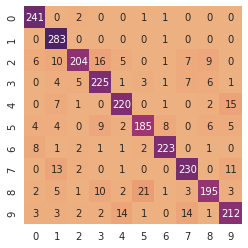

In [26]:
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            cmap='flare')

### Conclusions on the $k$-NN classifier

1. Initally, for K-NN classifier we used 7 number of neighbours (1, 2, 3, 5, 9, 17, 33) and Euclidean distance measure for nearest neighbour classification and after CV grid search observed that the highest mean scores were between 3 to 9 neighbours, i.e we get the best result considering this number of neighbours. 
2. The highest score belonged to $k=5$, but since not all $k$ values were tested, for further analysis we used another grid search with optimized 4 to 8 neighbour pixels and found that 4 neighbour had the highest mean score 0.9145, implying most of the pixels were surrounded by 4 neighbours of the right class.
3. Finally, we used 4 nearest neighbours to build a classifier and observed that the model showed an accuracy of 89%. It classified digit '1' most accurately. Also, it mostly gets confused when classifing between 5 and 8 & 4 and 9.


## MLP Classifier

### CV Hyperparametrization

Define an appropriate `MLPClassifier` and perform CV to select proper `alpha` and `hidden_layer_sizes` hyperparameters.

In [27]:
#define an appropriate MLP classifier and perform CV to select proper alpha and hidden_layer_sizes
n_folds = 2
skf = StratifiedKFold(n_folds, shuffle=True)

mlp_classifier = Pipeline(steps=[('std_sc', StandardScaler()),
                                 ('mlpc', MLPClassifier(solver='adam', 
                                              activation='relu',
                                              tol=1.e-4, 
                                              max_iter=1000,
                                              warm_start=False,
                                              shuffle=True))])

l_hidden_layer_sizes = [(128, 128), (128,64), (64, 32)]
l_alpha = [10.**k for k in range(-6, -2)]

param_grid = {'mlpc__alpha': l_alpha,
              'mlpc__hidden_layer_sizes': l_hidden_layer_sizes}

mlpc_gscv = GridSearchCV(mlp_classifier, 
                         param_grid=param_grid, 
                         cv=skf, 
                         scoring='accuracy', 
                         return_train_score=True, 
                         n_jobs=-1, 
                         verbose=3)

mlpc_gscv.fit(x_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('std_sc', StandardScaler()),
                                       ('mlpc', MLPClassifier(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'mlpc__alpha': [1e-06, 1e-05, 0.0001, 0.001],
                         'mlpc__hidden_layer_sizes': [(128, 128), (128, 64),
                                                      (64, 32)]},
             return_train_score=True, scoring='accuracy', verbose=3)

### Search Results 

We first examine the test scores of the 5 best hyperparameters.

In [28]:
#transfor the CV results into a DataFrame and display the 5 best results
df_cv_estimator = pd.DataFrame.from_dict(mlpc_gscv.cv_results_)

display(df_cv_estimator[["param_mlpc__alpha", "param_mlpc__hidden_layer_sizes", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False).head())

,param_mlpc__alpha,param_mlpc__hidden_layer_sizes,mean_test_score
7,0.0001,"(128, 64)",0.933867
6,0.0001,"(128, 128)",0.933067
1,0.000001,"(128, 64)",0.931867
9,0.001,"(128, 128)",0.931867
3,0.00001,"(128, 128)",0.931200


We analyze the CV results to check whether the CV ranges used are correct.

best alpha: 0.000100	
alpha_min: 0.000001	alpha_max: 0.001000
best_hidden_layer_sizes (128, 64) 
acc: 0.934

 1     0.931867
4     0.931067
7     0.933867
10    0.929067
Name: mean_test_score, dtype: float64


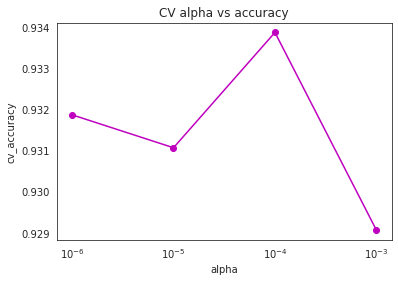

In [29]:
#plot the test scores that correspond to each alpha; do this only for the best MLP architecture found

best_alpha = mlpc_gscv.best_params_['mlpc__alpha'] 
print("best alpha: %.6f\t" % best_alpha)
print("alpha_min: %f\talpha_max: %f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))

best_hidden_layer_sizes = mlpc_gscv.best_params_['mlpc__hidden_layer_sizes'] 
print("best_hidden_layer_sizes", best_hidden_layer_sizes, "\nacc: %.3f" % mlpc_gscv.best_score_) 

idx_best_hidden_layer_sizes = [tup == best_hidden_layer_sizes for tup in df_cv_estimator['param_mlpc__hidden_layer_sizes'].values]
idx_best_hidden_layer_sizes = np.array(idx_best_hidden_layer_sizes)

print('\n', df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'])

plt.title("CV alpha vs accuracy")
plt.xscale('log')
plt.xlabel("alpha")
plt.ylabel("cv_accuracy")
plt.plot( df_cv_estimator[idx_best_hidden_layer_sizes]['param_mlpc__alpha'], 
              df_cv_estimator[idx_best_hidden_layer_sizes]['mean_test_score'],('mo-'))

### Test MLPC Performance

We check the test accuracy and confusion matrix.

In [30]:
#compute the test predictions, their accuracy and confusion matrix and discuss your results
y_pred = cross_val_predict(mlpc_gscv.best_estimator_, x_test, y_test, cv=skf, n_jobs=2)

acc    = accuracy_score(y_test, y_pred)
print("acc: %.3f" % (acc))

print("\nconfusion matrix:\n", confusion_matrix(y_test, y_pred))

acc: 0.896

confusion matrix:
 [[237   0   1   0   0   2   3   1   0   1]
 [  0 281   0   0   0   1   1   0   1   0]
 [  3   0 227   7   3   0   2   3  10   3]
 [  0   3   9 220   1   9   0   5   3   3]
 [  0   1   3   0 227   0   2   0   3  10]
 [  3   4   2   7   4 188   4   1   8   2]
 [  2   2   3   2   2   3 223   0   2   0]
 [  0   5   4   2   2   0   1 231   1  11]
 [  0   6   5   7   4   9   3   5 196   8]
 [  3   1   3   3  16   2   0  11   2 211]]


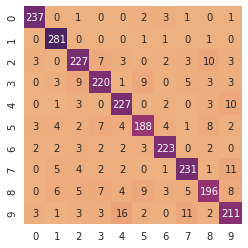

In [31]:
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            cmap='flare')

### Conclusions on the MLP classifier

1. The K-NN classifier results were good but not very impressive. So, in order to acheive better results we built a classifier using Multi-layer perceptron. For the mlp classifier we found that adam was a decent solver for weight optimization. It refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba.
2. We used 'relu' rectified linear unit which returns f(x) = max(0, x) as the activation function. The 2 fold CV and the following number of layers (128, 128), (128,64), (64, 32) were complete in 12 iterations. 3. We observed that the best hidden layer size was (128,64) with a learning rate $alpha$ of 0.0001 which gave a mean test score of 0.9338.
4. However, we found that the score  of layer size (128,128) with a learning rate of 0.0001 was 0.9330.
We assumed that the (128,128) layer would show better results due to more denser structure, but it was not the case.
5. The MLPC out performed the K-NN classifier by 0.9%. MLPC showed an accuracy of 89.6% and proved that using a MLP classifier we can acheive slightly better results. The confusion matrix for the MLP also shows that the decisions made by it are pretty accurate. 

### Predicting probabilities

We compute class probabilities over the test subset and pairplot them over the 10 classes.

In [32]:
#compute the test prediction probabilities, and pairplot them here
y_pred = mlpc_gscv.best_estimator_.predict_proba(x_test)

df_proba = pd.DataFrame(data=y_test, columns=['target'])
df_proba['max_prob'] = np.amax(y_pred,1)
df_proba['pred_target'] = np.argmax(y_pred,1)
df_proba.describe(include='all').round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
target,2500.0,4.44,2.90,0.00,2.0,4.0,7.0,9.0
max_prob,2500.0,0.98,0.07,0.31,1.0,1.0,1.0,1.0
pred_target,2500.0,4.42,2.89,0.00,2.0,4.0,7.0,9.0


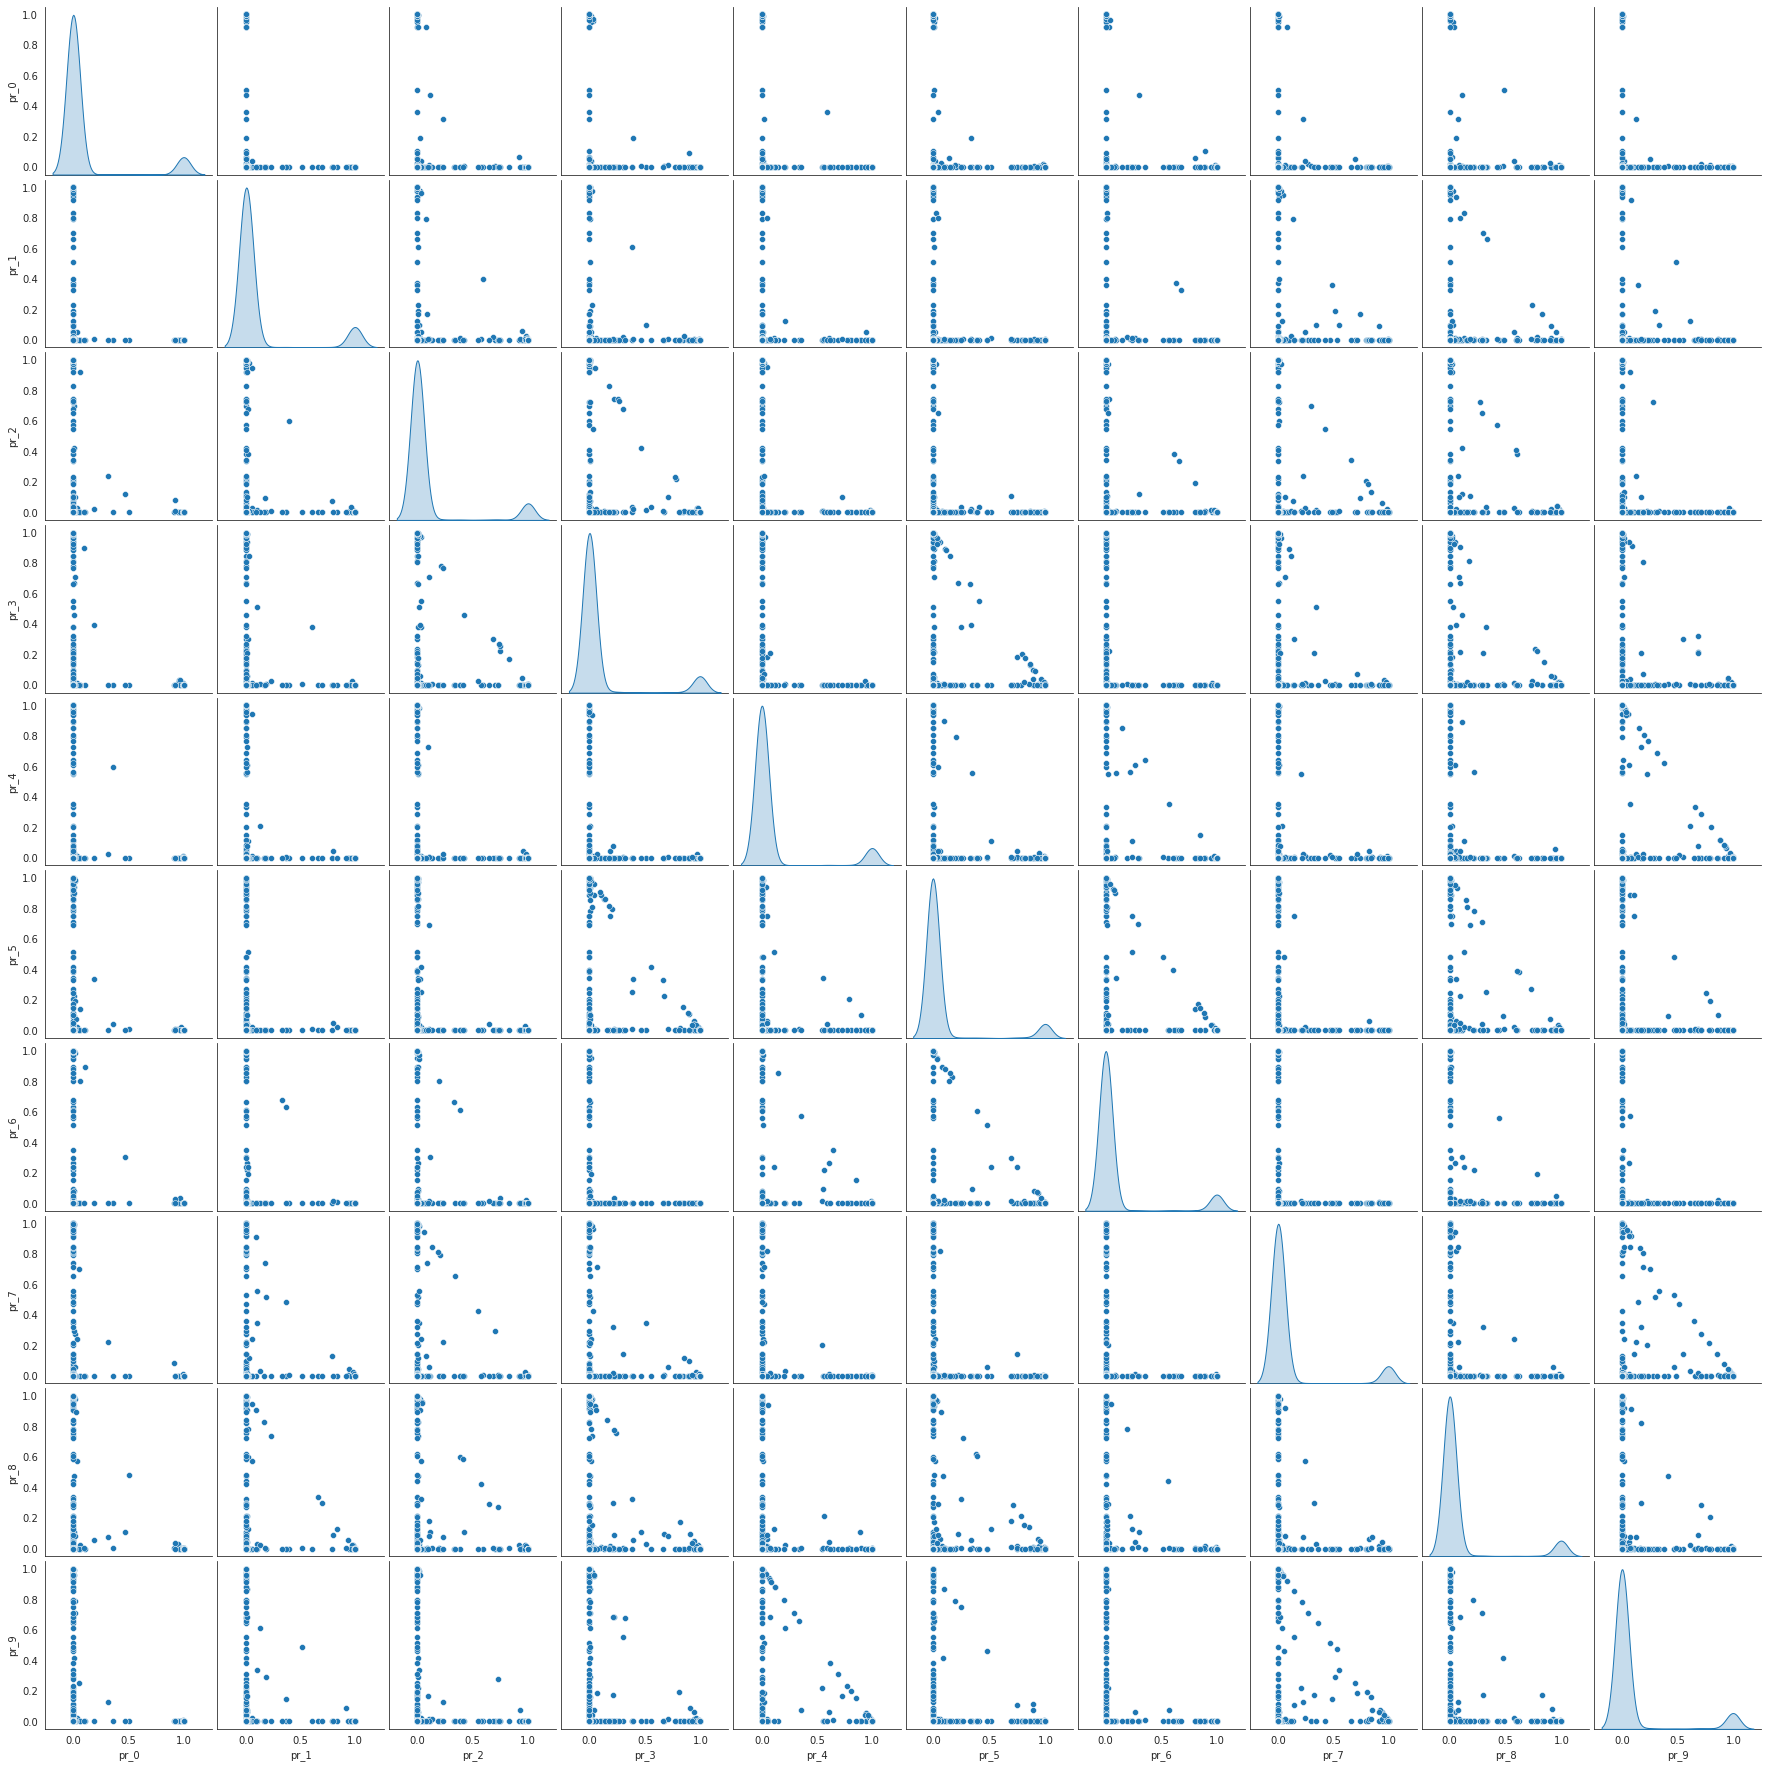

In [33]:
labels = [f'pr_{i}' for i in range(10)]

df_proba_pred_only = pd.DataFrame(data=y_pred, columns=labels)

pair_plot = sns.pairplot(
    df_proba_pred_only,
    diag_kind="kde",
    diag_kws=dict(shade=True))
plt.show()

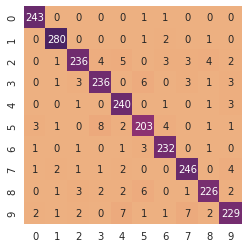

In [34]:
matrix_confusion = confusion_matrix(y_test, np.argmax(y_pred, 1))
sns.heatmap(matrix_confusion,
            square=True,
            annot=True,
            fmt='d',
            cbar=False,
            cmap='flare')

### Conclusions on the probability pairplots

1. The pair plot shows a clear picture of the model's performance. As we can see in the pair plots the model did a nice job of classifying digits properly. However, there are a few cases (around 10%) where the MLPC is confused as the digits were written in a very similar way and the pixels on the diagnoal takes a value of 0.5 for probability distribution.
2. The confusion matrix displays the number of correctly classified and misclassified digits. As we can see that the number of misclassified digits had dropped significantly for MLPC incomparison to K-NN. It was able to differentiate between 5 & 8 distinctively. However, for MLPC it's still sometimes difficult  to differentiate between 4 & 9 as they are written in a really similar way. 

### What went wrong?

Probably your classification results are not very impressive.

As a first step to interpret them, find 10 cases of wrongly classified numbers, plot them and discuss your findings.  

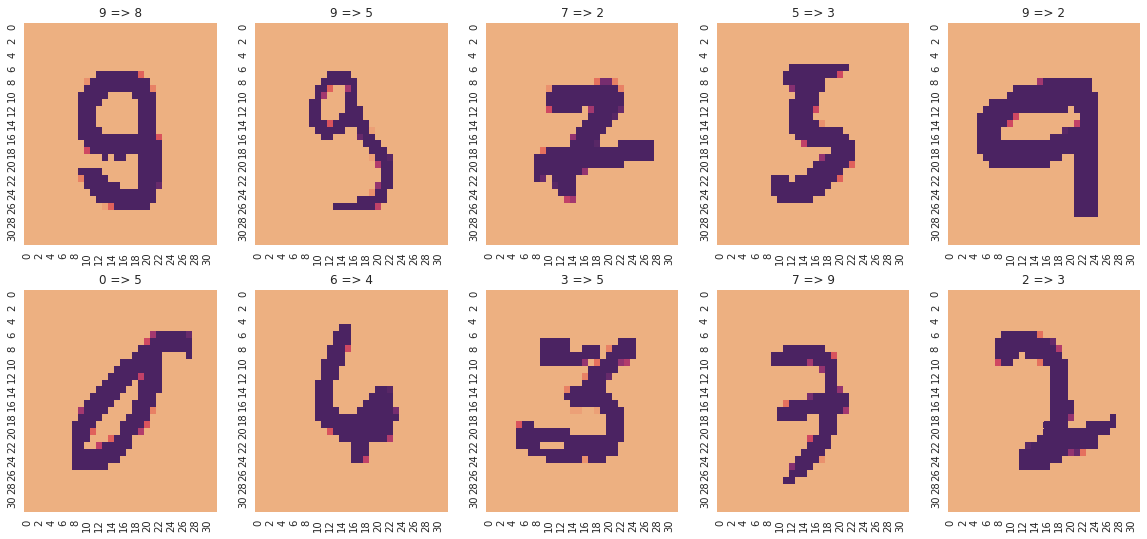

,label,pred_label,confidence
0,9,8,0.478492
1,9,5,0.886433
2,7,2,0.998427
3,5,3,0.893568
4,9,2,0.973790
5,0,5,0.989275
6,6,4,0.998197
7,3,5,0.862002
8,7,9,0.551302
9,2,3,0.782943


In [35]:
#find these examples and plot the images here

plt.figure(figsize=(20, 9))
misclassifications = []
i = 0
while len(misclassifications) < 10:
  if y_test[i] != np.argmax(y_pred[i]):
    misclassifications.append({
        'label': y_test[i],
        'pred_label': np.argmax(y_pred[i]),
        'confidence': np.max(y_pred[i])
    })
    plt.subplot(2, 5, len(misclassifications))
    plt.title(f'{y_test[i]} => {np.argmax(y_pred[i])}')
    h_map = sns.heatmap(x_test[i].reshape(32, 32),
                    vmin=0., vmax=16., 
                    cmap='flare', 
                    cbar=False,
                   )
  i += 1
plt.show()

df_error = pd.DataFrame(misclassifications)
df_error.head(10)

**Discussion**
1. As seen in the above figure and table the model sometimes misclassify the digits with a high confidence. This implies that the model has incorrectly learned the pixel arrangment for digits in some extreme cases. 
2. One of the possible reason for that is, as we are using a smaller data set. The model wasn't able to learn all the possible scenarios in which the digits can be written. 
3. Other, plausible explaination for the misclassification can be the similarity in the way of writting the digits. For example, some times the distribution of pixels for digit 4, is very similar to that of pixel distribution on digit 9. Implying that 4 and 9 were written in a very similar way. Other example of such case is digit 5 and digit 8.

## How to improve your results?

1. Using the $K-NN$ classifier we got an accuracy of 88.7%. Inorder to acheive, better results we tried MLP classifier and our results improved by 0.9% and we got an final accuracy of 89.6%. The training time for the model was less than 10 mins with (128,64) hidden layer size.
2. We can improve the obtained results probably by using a large dataset for training. As using a larger dataset will help our model to learn more variations in writing of digits.
3. Much better results can be obtained by doing a more exhaustive grid search in order to find a optimum set of parameter. However, we weren't able to perform a extensive grind search due to GPU constraints.
4. We can use decision tree models like random forest or ensemble models like XGboost or adaboost for improved results.  
5. Finally, to improve the overall classification accuracy CNN models can also be implemented.